# Steps

This document is research of semantic similarity between texts implementins scripts steps.

In [1]:
# import used modules
import os
import numpy as np
import time
import pickle

In [2]:
# import a model and a module for semantic analys
import gensim
model = gensim.models.KeyedVectors.load_word2vec_format('../../model.bin', binary=True) 
model.init_sims(replace=True)

/home/ased/anaconda3/lib/python3.5/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [3]:
# import our module for semantic analys
import sys
sys.path.append('../../')
import sem_analysis as sa


Loading the model...
Processing input...


## 1. Extract Sentences From Documents And Their Preprocessing

In [126]:
files = dict()
for i in os.listdir():
    if os.path.isdir(i) and i.isdigit():
        for j in os.listdir(i):
            name = i + '/' + j
            f = open(name, 'r')
            files[i + '/' + j] = f.read()
            f.close()

In [127]:
import numpy as np
n = len(files.keys())
D = np.zeros((n, n))
keys = list(files.keys())
keys.sort()
texts = [files[i] for i in keys]
len(texts)

70

Now we transform our phrases to format for [RusVectores](https://rusvectores.org/ru/). See [tutorial for RusVectores](https://github.com/akutuzov/webvectors/blob/master/preprocessing/rusvectores_tutorial.ipynb).

In [128]:
name_pickle = 'texts_transform.pickle'
if not name_pickle in os.listdir():
    t = time.time()
    texts_transform = list()
    for i in texts:
        texts_transform.append(sa.tag_ud(i))
        if len(texts_transform) % 10 == 0:
            print(len(texts_transform), time.time() - t)
    with open(name_pickle, 'wb') as f:
        pickle.dump(texts_transform, f)
        f.close()
else:
    with open(name_pickle, 'rb') as f: 
        texts_transform = pickle.load(f)
        f.close()

## 2. Quallity Of Separation

## 2.1. Texts Subsets

Mean precision, mean recall, mean accuracy

In [136]:
list_keys = ['4', '6', '7', '9']
cur_centers = [centers[ind] for ind, i in  enumerate(names) if i.split('/')[0] in list_keys]
cur_names = [i for ind, i in  enumerate(names) if i.split('/')[0] in list_keys]
_ = [i.split('/')[0] for i in names]
cur_dict=dict()
for ind, i in enumerate(_):
    if i in list_keys:
        if not cur_dict.__contains__(i):
            cur_dict[i] = list()
        cur_dict[i].append((centers[ind], names[ind]))
cur_dict = {i:cur_dict[i][:7] for i in cur_dict}
cur_names = list()
for _ in [[j[1] for j in cur_dict[i]] for i in list_keys]:
    for item in _:
        cur_names.append(item)
cur_centers = list()
for _ in [[j[0] for j in cur_dict[i]] for i in list_keys]:
    for item in _:
        cur_centers.append(item)
d = cur_dict
d = {i:[j[0] for j in d[i]] for i in list_keys}
print(len(cur_centers), len(cur_names))

28 28


In [146]:
from itertools import combinations,product
keys = list(d.keys())
true_spheres = {i:[ind for ind,j in enumerate(cur_names) if i ==j.split('/')[0]] for i in list_keys}
res = list()
for num_item in range(1, len(d[list(d.keys())[0]]) + 1):
    C = dict()
    C = {i:[sum(list(j))/num_item for j in combinations(d[i], num_item)] for i in d}
    _ = [C[i] for i in keys]
    dicts = [{keys[ind]:j for ind,j in enumerate(list(i))} for i in product(*_)]
    recall, prec, acc = list(), list(), list()
    print(len(dicts), num_item)
    for i in dicts:
        full_spheres = get_separation(cur_centers, i)
        item1, item2, item3 = full_acc(true_spheres, full_spheres, with_print = False)
        recall.append(item1)
        prec.append(item2)
        acc.append(item3)
    res.append([sum(recall)/len(recall),
               sum(prec)/len(prec),
               sum(acc)/len(acc)])

2401 1
194481 2
1500625 3
1500625 4
194481 5
2401 6
1 7


In [166]:
with open('res.pickle', 'wb') as f:
    pickle.dump(res, f)
    f.close()

In [147]:
import pandas as pd
Q = np.array(res)
pd.DataFrame(Q, 
             columns = ['Recall', 'Precision', 'Accuracy'], 
             index = [i for i in range(1, len(d[list(d.keys())[0]]) + 1)])

,Recall,Precision,Accuracy
1,0.633575,0.731000,0.633575
2,0.757591,0.797170,0.757591
3,0.835391,0.854682,0.835391
4,0.885787,0.897799,0.885787
5,0.921939,0.930246,0.921939
6,0.951687,0.957115,0.951687
7,0.964286,0.968750,0.964286


<IPython.core.display.Javascript object>


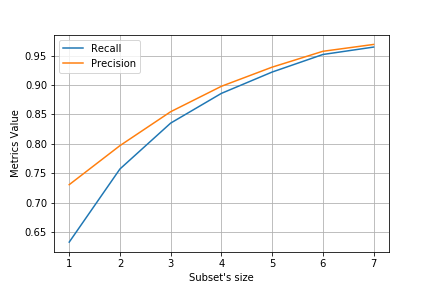

Text(0, 0.5, 'Metrics Value')

In [171]:
import matplotlib.pyplot as plt
%matplotlib notebook
x = [i for i in range(1, Q.shape[0]+1)]
y1, y2 = Q[:,0], Q[:,1]
plt.plot(x, y1)
plt.plot(x, y2)
plt.legend(['Recall', 'Precision'])
plt.grid()
plt.xlabel("Subset's size")
plt.ylabel('Metrics Value')

## 2.2. Full Texts Set

In [152]:
name_pickle = 'texts_transform.pickle'
with open(name_pickle, 'rb') as f: 
    texts_transform = pickle.load(f)
    f.close()
centers = list()
for j in texts_transform:
    new = [model[i] for i in j if model.__contains__(i)]
    centers.append(sum(new)/len(new))

In [153]:
names = list(files.keys())
names.sort()
_ = [i.split('/')[0] for i in names]
cur_dict=dict()
for ind, i in enumerate(_):
    if not cur_dict.__contains__(i):
        cur_dict[i] = list()
    cur_dict[i].append(centers[ind])

In [154]:
spheres = dict()
for i in cur_dict:
    c = sum(cur_dict[i]) / len(cur_dict[i])
    spheres[i] = (c, max([np.linalg.norm(c - j) for j in cur_dict[i]]))

In [155]:
def get_separation(centers, spheres):
    full_spheres = {i: list() for i in spheres}
    for ind, j in enumerate(centers):
        m, r = None, np.inf
        for key in spheres:
            if m is None or r > np.linalg.norm(spheres[key] - j):
                m, r = key, np.linalg.norm(spheres[key] - j)
        full_spheres[m].append(ind)
    return full_spheres

In [156]:
full_spheres = get_separation(centers, {i:spheres[i][0] for i in spheres})

In [157]:
def metric(list1, list2):
    TP = len([i for i in list2 if i in list1])
    FP = len([i for i in list2 if not i in list1])
    FN = len([i for i in list1 if not i in list2])
    return TP/(TP+FN), TP/(FP+TP)
def full_acc(true_spheres, full_spheres, with_print = True):
    keys = list(true_spheres.keys())
    keys = [int(i) for i in keys]
    keys.sort()
    keys = [str(i) for i in keys]
    if with_print:
        print("Number, Recall, Precision")
    s, fs = 0., 0.
    recall, precision = list(), list()
    for i in keys:
        _1, _2 = metric(true_spheres[i], full_spheres[i])
        recall.append(_1)
        precision.append(_2)
        if with_print:
            print(i, recall[-1], precision[-1])
        s += len([j for j in full_spheres[i] if j in true_spheres[i]])
        fs += len(true_spheres[i])
    return sum(recall)/len(recall), sum(precision)/len(precision), s/fs

In [158]:
true_spheres = {i:[ind for ind,j in enumerate(names) if i ==j.split('/')[0]] for i in spheres}
full_acc(true_spheres, full_spheres)

Number, Recall, Precision
0 1.0 1.0
1 1.0 1.0
2 1.0 0.8
3 0.8571428571428571 0.6666666666666666
4 0.6666666666666666 0.75
5 0.8333333333333334 0.8333333333333334
6 0.75 0.8571428571428571
7 0.875 0.875
8 0.8 1.0
9 1.0 1.0
10 1.0 1.0
11 1.0 1.0


(0.8985119047619047, 0.8985119047619047, 0.8714285714285714)

## 3. Research Distance Between Steps

In [159]:
name_pickle = 'texts_transform.pickle'
with open(name_pickle, 'rb') as f: 
    texts_transform = pickle.load(f)
    f.close()
centers = list()
for j in texts_transform:
    new = [model[i] for i in j if model.__contains__(i)]
    centers.append(sum(new)/len(new))

In [160]:
names = list(files.keys())
names.sort()
_ = [i.split('/')[0] for i in names]
cur_dict=dict()
for ind, i in enumerate(_):
    if not cur_dict.__contains__(i):
        cur_dict[i] = list()
    cur_dict[i].append(centers[ind])

### 3.1. Distance Between Steps Centers

In [162]:
n = len(spheres.keys())
D_centers = np.zeros((n,n))
keys = [i for i in range(0, n)]
for i in keys:
    for j in keys:
        D_centers[i,j] = np.linalg.norm(spheres[str(i)][0] - spheres[str(j)][0])

In [163]:
import pandas as pd
pd.DataFrame(D_centers)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.000000,0.186481,0.189814,0.159948,0.189155,0.214254,0.163731,0.228201,0.266157,0.172369,0.157634,0.248050
1,0.186481,0.000000,0.184479,0.183067,0.209134,0.170573,0.191442,0.259894,0.299288,0.172414,0.157767,0.271436
2,0.189814,0.184479,0.000000,0.124397,0.165187,0.152620,0.167136,0.172860,0.223444,0.168513,0.130206,0.230869
3,0.159948,0.183067,0.124397,0.000000,0.140407,0.169207,0.144816,0.196055,0.241608,0.161607,0.120623,0.238084
4,0.189155,0.209134,0.165187,0.140407,0.000000,0.181466,0.102595,0.212918,0.271278,0.196835,0.150865,0.230424
5,0.214254,0.170573,0.152620,0.169207,0.181466,0.000000,0.191939,0.230440,0.278785,0.166034,0.149185,0.248171
6,0.163731,0.191442,0.167136,0.144816,0.102595,0.191939,0.000000,0.219710,0.274943,0.189920,0.151927,0.242950
7,0.228201,0.259894,0.172860,0.196055,0.212918,0.230440,0.219710,0.000000,0.119390,0.215929,0.206861,0.215655
8,0.266157,0.299288,0.223444,0.241608,0.271278,0.278785,0.274943,0.119390,0.000000,0.258760,0.254001,0.230963
9,0.172369,0.172414,0.168513,0.161607,0.196835,0.166034,0.189920,0.215929,0.258760,0.000000,0.156122,0.245486


### 3.2. Statistic Information

In [164]:
D_st = np.array([(D_centers+1000*np.eye(n)).min(axis = 1), (D_centers+1000*np.eye(n)).argmin(axis = 1), 
                 D_centers.max(axis = 1), D_centers.argmax(axis = 1),
                 D_centers.mean(axis = 1)])
D_st = D_st.transpose()
pd.DataFrame(D_st, columns = ['MIN', 'ARGMIN','MAX', 'ARGMAX', 'MEAN'])

,MIN,ARGMIN,MAX,ARGMAX,MEAN
0,0.157634,10.0,0.266157,8.0,0.181316
1,0.157767,10.0,0.299288,8.0,0.190498
2,0.124397,3.0,0.230869,11.0,0.159127
3,0.120623,10.0,0.241608,8.0,0.156652
4,0.102595,6.0,0.271278,8.0,0.170855
5,0.149185,10.0,0.278785,8.0,0.179390
6,0.102595,4.0,0.274943,8.0,0.170093
7,0.119390,8.0,0.259894,1.0,0.189826
8,0.119390,7.0,0.299288,1.0,0.226551
9,0.156122,10.0,0.258760,8.0,0.175332


## 3.3 Internal Distance

In [165]:
new = 0.
for i in full_spheres:
    for j in full_spheres[i]:
        d = np.array([np.linalg.norm(c - centers[j]) for c in centers])
        d[j] += 1000
        if not d.argmin() in full_spheres[i]:
            new+=1
print("%.3f"%(1 - new/len(centers)))

0.657
